# Blind source separation with GMCA and AMCA
### or how to do sparse BSS with partially correlated sources

In [1]:
# Useful packages
import matplotlib.pyplot as plt
import numpy as np
from pyGMCA.common import utils as bu
from pyGMCA.bss import amca, gmca

%matplotlib inline
font = {
    'weight': 'bold',
    'size': 12,
}
plt.rcParams["figure.figsize"] = (20, 10)
plt.rc('font', **font)

N_MC = 10 # Number of Monte-Carlo simulations

### Good things to know about the GMCA and AMCA algorithms

Both algorithms basically run as follows:

Rg = gmca.GMCA(X0,n=n) or Ra = amca.AMCA(X0,n=n)

Where:

    - X0 is a m x t matrix, that is composed of m observations of t samples; should already be expressed in the sparse domain
    - n is the number of sources to be estimated
    
The output is a dictionary with entries:

    - "sources" is the n x t matrix of estimated sources
    - "mixmat" is the m x n mixing matrix
    - "weights" : for AMCA, these are the estimated sample weights
    
Extra parameters are:

    - UseP : thresholding strategy
           > 0 is the standard k-mad threshold 
           > 1 is based on the support of the estimated sources, which is increased at each iteration
           > 2 same as 1 but adapted to very sparse sources (e.g. spiky sources)
    - maxts : initial value of k for UseP = 0
    - mints : final value of k
    - nmax : number of iterations
    - L0 : if set to 1, implements a hard rather than soft-thresholding
    - q_f (in AMCA) : final weight parameter
    - Aposit : if set to True, imposes the positivity of the mixing matrix
    - BlockSize : block size in case a block-based optimization is performed
    - NoiseStd : vector of noise std per observation
    - IndNoise : vectors of indices that indicates which samples are used to estimate the noise level
    - Kmax : max L0 norm for the sources
    - AInit : initial point for A
    - Init : is set to 0, random initialization; if 1, PCA-based
    - tol : upper limit on the stopping criterion


## Comparing GMCA and AMCA when sparsity is enforced in the sample domain
### Evolution of the mixing matrix criterion when the sparsity level varies

/home/ruizca/.conda/envs/gmcadev/lib/python3.9/site-packages/pyGMCA-1.0-py3.9.egg/pyGMCA/common/utils.py:400: RuntimeWarning: invalid value encountered in arccos


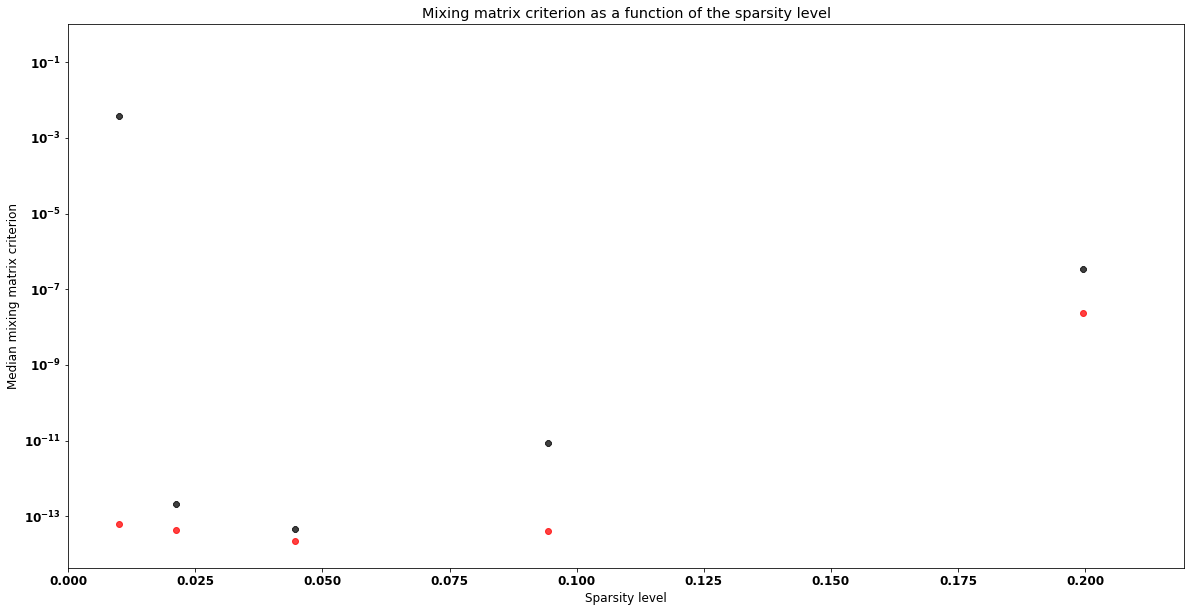

In [2]:
n = 4
m = 4
t = 2048
p1 = 0.1
sigma1 = 4
pval = np.power(10,np.linspace(-2, -0.7, 5))

C_G_sparse_level = np.zeros((5, N_MC))
C_A_sparse_level = np.zeros((5, N_MC))

for It_MC in range(N_MC):
    for R_p in range(5):
        p = pval[R_p]
        X, X0, A0, S0, N, sigma_noise, kern = bu.Make_Experiment_Coherent(
            n_s=n, n_obs=m, t_samp=t, w=0.1, noise_level=120, dynamic=0, sigma1=sigma1, p1=p1, ptot=p
        )
        Rg = gmca.GMCA(X0, n=n, mints=0, nmax=500, L0=0, UseP=1)
        crit = bu.EvalCriterion(A0, S0, Rg["mixmat"], Rg["sources"])
        C_G_sparse_level[R_p, It_MC] = crit["ca_med"]
        Ra = amca.AMCA(X0, n, mints=0, nmax=500, q_f=0.1, L0=1, UseP=1)
        crit = bu.EvalCriterion(A0,S0,Ra["mixmat"], Ra["sources"])
        C_A_sparse_level[R_p, It_MC] = crit["ca_med"]

# PLOTTING THE RESULTS
plt.figure()
plt.title('Mixing matrix criterion as a function of the sparsity level')
tempG = np.median(C_G_sparse_level, 1)
tempA = np.median(C_A_sparse_level, 1)
Mrange = 5**np.max([np.max(tempA), np.max(tempG)])
mrange = 0.2*np.min([np.min(tempA), np.min(tempG)])
plt.semilogy(pval, tempG, 'k8', alpha=0.75)
plt.semilogy(pval, tempA, 'ro', alpha=0.75)
plt.axis([0, 1.1*np.max(pval), mrange, Mrange])
plt.xlabel("Sparsity level")
plt.ylabel("Median mixing matrix criterion")
plt.show()

### Evolution of the mixing matrix criterion when the correlation level varies

/home/ruizca/.conda/envs/gmcadev/lib/python3.9/site-packages/pyGMCA-1.0-py3.9.egg/pyGMCA/common/utils.py:400: RuntimeWarning: invalid value encountered in arccos


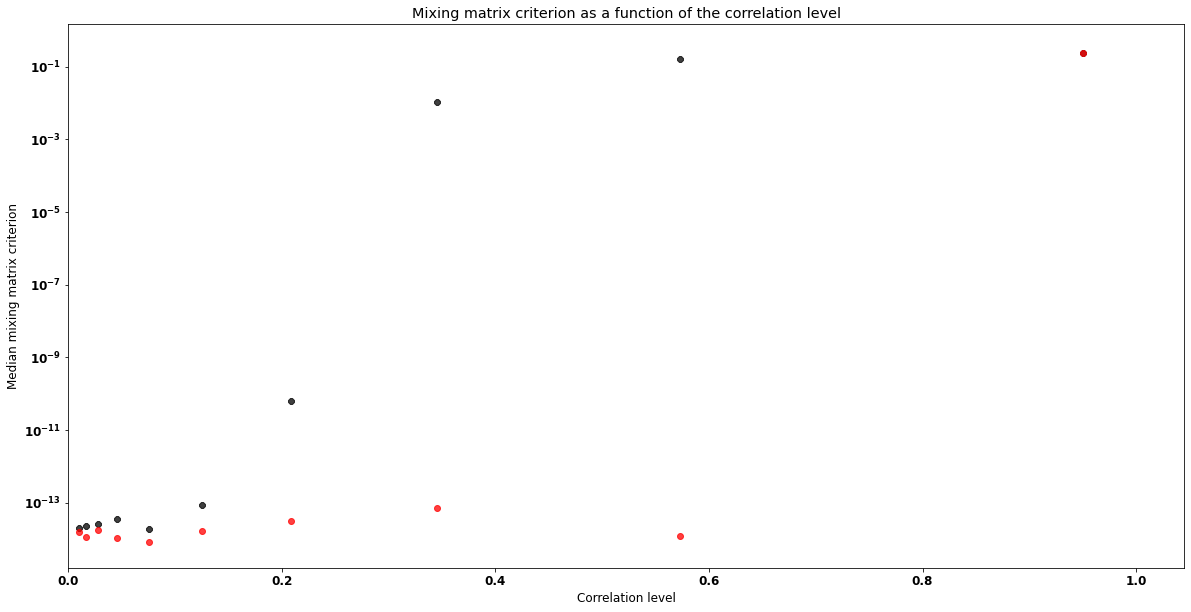

In [3]:
n = 4
m = 4
t =2048
p1 = 0.1
sigma1 = 4
p = 0.05
pval = np.power(10, np.linspace(-2, np.log10(0.95), 10))

C_G_corr_level = np.zeros((10, N_MC))
C_A_corr_level = np.zeros((10, N_MC))

for It_MC in range(N_MC):
    for R_p in range(10):
        p1 = pval[R_p]
        X, X0, A0, S0, N,sigma_noise, kern = bu.Make_Experiment_Coherent(
            n_s=n, n_obs=m, t_samp=t, w=0.1, noise_level=120, dynamic=0, sigma1=sigma1, p1=p1, ptot=p
        )
        Rg = gmca.GMCA(X0, n=n, mints=0, nmax=500, L0=0, UseP=1)
        crit = bu.EvalCriterion(A0, S0, Rg["mixmat"], Rg["sources"])
        C_G_corr_level[R_p, It_MC] = crit["ca_med"]
        Ra = amca.AMCA(X0, n, mints=0, nmax=500, q_f=0.1, L0=1, UseP=1)
        crit = bu.EvalCriterion(A0, S0, Ra["mixmat"],Ra["sources"])
        C_A_corr_level[R_p, It_MC] = crit["ca_med"]

# PLOTTING THE RESULTS
plt.figure()
plt.title('Mixing matrix criterion as a function of the correlation level')
tempG = np.median(C_G_corr_level, 1)
tempA = np.median(C_A_corr_level, 1)
Mrange = 5.**np.max([np.max(tempA), np.max(tempG)])
mrange = 0.2*np.min([np.min(tempA), np.min(tempG)])
plt.semilogy(pval, tempG,'k8', alpha=0.75)
plt.semilogy(pval, tempA,'ro', alpha=0.75)
plt.axis([0, 1.1*np.max(pval), mrange, Mrange])
plt.xlabel("Correlation level")
plt.ylabel("Median mixing matrix criterion")
plt.show()

### Evolution of the mixing matrix criterion when the dynamic range varies

In [ ]:
n = 4
m = 4
t = 2048
p1 = 0.3
sigma1 = 4
p = 0.1
pval = np.linspace(0, 4, 10)

C_G_dyn_level = np.zeros((10, N_MC))
C_A_dyn_level = np.zeros((10, N_MC))

for It_MC in range(N_MC):
    for R_p in range(10):
        dyna = pval[R_p]
        X, X0, A0, S0, N, sigma_noise, kern = bu.Make_Experiment_Coherent(
            n_s=n, n_obs=m, t_samp=t, w=0.1, noise_level=120, dynamic=dyna, sigma1=sigma1, p1=p1, ptot=p
        )
        Rg = gmca.GMCA(X0, n=n, mints=0, nmax=500, L0=0, UseP=1)
        crit = bu.EvalCriterion(A0, S0, Rg["mixmat"], Rg["sources"])
        C_G_dyn_level[R_p, It_MC] = crit["ca_med"]
        Ra = amca.AMCA(X0, n,mints=0, nmax=500, q_f=0.1, L0=1, UseP=1)
        crit = bu.EvalCriterion(A0, S0, Ra["mixmat"], Ra["sources"])
        C_A_dyn_level[R_p, It_MC] = crit["ca_med"]

# PLOTTING THE RESULTS
plt.figure()
plt.title('Mixing matrix criterion as a function of the dynamic')
tempG = np.median(C_G_dyn_level, 1)
tempA = np.median(C_A_dyn_level, 1)
Mrange = 5.**np.max([np.max(tempA), np.max(tempG)])
mrange = 0.2*np.min([np.min(tempA), np.min(tempG)])
plt.semilogy(pval, tempG, 'k8', alpha=0.75)
plt.semilogy(pval, tempA, 'ro', alpha=0.75)
plt.axis([0, 1.1*np.max(pval), mrange, Mrange])
plt.xlabel("Dynamic range")
plt.ylabel("Median mixing matrix criterion")
plt.show()

/home/ruizca/.conda/envs/gmcadev/lib/python3.9/site-packages/pyGMCA-1.0-py3.9.egg/pyGMCA/common/utils.py:400: RuntimeWarning: invalid value encountered in arccos
